## T5 трансформер для перевода с немецкого на английский

Сегодня вы поработаете над настоящей задачей NLP и попробуете обучить трансформер переводить короткие предложения с английского на немецкий.

Токенизацию и блоки трансформера писать не придётся — будем пользоваться библиотекой `transformers`.

Наши задачи:
- Познакомиться с наиболее популярным методом токенизации текстов — byte pair encoding
- Научиться пользоваться токенизатором из `transformers`
- Подготовить даннные
- Обучить готовую архитектуру T5-small под нашу задачу
- Исследовать разные стратегии декодирования с помощью обученной модели

In [1]:
%%capture
!pip install lightning
!pip install transformers
!pip install datasets
import math
from pathlib import Path
from typing import cast

import lightning as L
import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset
from transformers import T5ForConditionalGeneration, T5Tokenizer

from datasets import load_dataset, load_from_disk

In [2]:
torch.manual_seed(42)

#### Готовим данные

In [3]:
train_dataset = load_dataset("bentrevett/multi30k", split="train")
test_dataset = load_dataset("bentrevett/multi30k", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
train_dataset[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

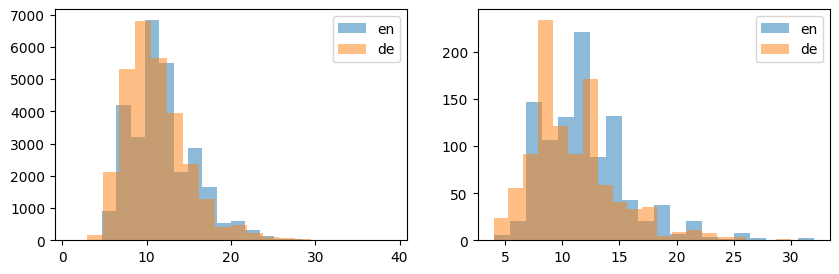

In [5]:
import matplotlib.pyplot as plt


def length_histogram(dataset, ax, bins=20) -> None:
    en_lengths = []
    de_lengths = []
    for sample in dataset:
        en_lengths.append(len(sample["en"].split(" ")))
        de_lengths.append(len(sample["de"].split(" ")))

    ax.hist(en_lengths, alpha=0.5, bins=bins, label="en")
    ax.hist(de_lengths, alpha=0.5, bins=bins, label="de")
    ax.legend()


fig, axes = plt.subplots(1, 2, figsize=(10, 3))
length_histogram(train_dataset, axes[0])
length_histogram(test_dataset, axes[1])

Оставим только сравнительно короткие предложения, чтобы можно было чему-то научиться за короткое время

In [6]:
maxlen = 8


def filter_dataset(dataset, maxlen: int) -> list[dict[str, str]]:
    return [
        dataset[i]
        for i in range(len(dataset))
        if len(dataset[i]["en"].split(" ")) <= maxlen
    ]


train_filtered = filter_dataset(train_dataset, maxlen)
test_filtered = filter_dataset(test_dataset, maxlen)

print(len(train_filtered), len(test_filtered))

5144 174


##### Токенизация: byte-pair encoding

Построение:

Начинаем со словаря, состоящего из отдельных символов (начальные токены).
На каждом шаге:
1. Оцениваем частоту всех пар токенов внутри слов, находим самую частую
2. Добавляем её в список токенов и в таблицу слияний
3. Останавливаемся, когда достигаем максимального размера словаря


Применение:

1. Разбиваем текст на символы
2. Находим первое возможное слияние в таблице и применяем его
3. Останавливаемся, когда дальнейшие слияния невозможны

<img src="https://lena-voita.github.io/resources/lectures/seq2seq/bpe/build_merge_table.gif" style="background:white" height="300"/>
<img src="https://lena-voita.github.io/resources/lectures/seq2seq/bpe/bpe_apply.gif" style="background:white" height="300"/>


Реализаций много, мы будем использовать токенизатор  из библиотеки `transformers`, где помимо самого подготовленного токенизатора (`sentencepiece.SentencePieceProcessor`) много полезных методов для кодирования и декодирования.

Добавим при создании новый токен, который будет указывать на начало перевода

In [7]:
tokenizer: T5Tokenizer = T5Tokenizer.from_pretrained(
    "t5-small", padding_size="right", bos_token="</b>", legacy=False
)

In [8]:
print("Размер словаря: ", len(tokenizer))

Размер словаря:  32101


Посмотрим на примеры токенов, в них встречаются и целые слова из разных языков, и числительные, и знаки препинания:

In [9]:
import random

random.choices(list(tokenizer.get_vocab().items()), k=10)

[('▁Jeep', 21145),
 ('н', 7184),
 ('▁Ep', 10395),
 ('▁Earth', 4030),
 ('▁complicated', 6446),
 ('strahl', 16421),
 ('omb', 8038),
 ('ateurs', 12552),
 ('croft', 30750),
 ('▁soutenu', 30362)]

Токенизатор в работе: кодирование и декодирование предложений на немецком и английском:

In [10]:
encoded_german = tokenizer.encode(train_dataset[0]["de"])
encoded_english = tokenizer.encode(train_dataset[0]["en"])
print(encoded_german)
print(tokenizer.decode(encoded_german))
print(encoded_english)
print(tokenizer.decode(encoded_english))

[11280, 16815, 7838, 15, 16282, 436, 256, 8671, 35, 16, 74, 13271, 2221, 49, 21162, 3992, 5, 1]
Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.</s>
[2759, 1021, 6, 1945, 5069, 7, 33, 1067, 1084, 186, 3, 30271, 5, 1]
Two young, White males are outside near many bushes.</s>


Об упаковке в батчи можно больше не беспокоиться — токенизатор умеет обрабатывать сразу пачку примеров

In [11]:
batch = [train_dataset[i]["en"] for i in range(4)]

encoded_batch = tokenizer.batch_encode_plus(
    batch, padding="longest", return_tensors="pt"
)
print(encoded_batch["input_ids"].shape)
print(encoded_batch.keys())

torch.Size([4, 19])
dict_keys(['input_ids', 'attention_mask'])


Возвращается два значения: `input_ids` — это наши токены, а `attention_mask` — это тензор, равный по размеру батчу токенов, где на месте `pad_token` стоят нули, в остальных позициях — единицы. Это нам понадобится потом.

А ещё можно кодировать сразу входные и выходные данные:

In [12]:
inputs = [train_dataset[i]["en"] + tokenizer.bos_token for i in range(4)]
targets = [train_dataset[i]["de"] for i in range(4)]

encoded_batch = tokenizer(
    inputs, text_target=targets, padding="longest", return_tensors="pt"
)
print(encoded_batch.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


Используем это в `collate_fn` для сборки батчей:

In [13]:
def collate_fn(
    tokenizer: T5Tokenizer, batch: list[tuple[str, str]]
) -> tuple[Tensor, Tensor]:
    prompt = tokenizer.bos_token
    inputs, targets = zip(*[(pair["de"], prompt + pair["en"]) for pair in batch])
    encoded_batch = tokenizer(
        inputs, text_target=targets, padding="longest", return_tensors="pt"
    )
    return encoded_batch

In [14]:
batch = [train_dataset[i] for i in range(4)]
encoded_batch = collate_fn(tokenizer, batch)
print(encoded_batch.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [15]:
print(encoded_batch["input_ids"].shape)
print(encoded_batch["attention_mask"].shape)
print(encoded_batch["labels"].shape)

torch.Size([4, 22])
torch.Size([4, 22])
torch.Size([4, 20])


Всё готово для получения минибатчей из датасетов:

In [16]:
train_loader = DataLoader(
    train_filtered,
    batch_size=32,
    shuffle=True,
    collate_fn=lambda batch: collate_fn(tokenizer, batch),
)
test_loader = DataLoader(
    test_filtered,
    batch_size=32,
    shuffle=False,
    collate_fn=lambda batch: collate_fn(tokenizer, batch),
)

#### Задание 1 (3 балла). DataModule

Реализуйте подкласс `lightning.LightningDataModule` для работы с обучающим и тестовым датасетами

In [17]:
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS


class Multi30kDataset(L.LightningDataModule):
    train_dataset: Dataset
    test_dataset: Dataset
    tokenizer: T5Tokenizer

    def __init__(self, maxlen: int = 0, batch_size: int = 32) -> None:
        self.maxlen = maxlen
        self.batch_size = batch_size
        self.tokenizer = tokenizer

    def setup(self, stage: str = None):
        self.train_dataset = self.filter_dataset(train_dataset, self.maxlen)
        self.test_dataset = self.filter_dataset(test_dataset, self.maxlen)

    def filter_dataset(self, dataset, maxlen: int) -> list[dict[str, str]]:
        return [
            dataset[i]
            for i in range(len(dataset))
            if len(dataset[i]["en"].split(" ")) <= maxlen
        ]

    def collate_fn(
        self, tokenizer: T5Tokenizer, batch: list[tuple[str, str]]
    ) -> tuple[Tensor, Tensor]:
        prompt = tokenizer.bos_token
        inputs, targets = zip(*[(pair["de"], prompt + pair["en"]) for pair in batch])
        encoded_batch = tokenizer(
            inputs, text_target=targets, padding="longest", return_tensors="pt"
        )
        return encoded_batch

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=lambda batch: self.collate_fn(self.tokenizer, batch)
        )

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=lambda batch: self.collate_fn(self.tokenizer, batch)
        )

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return self.val_dataloader()

In [18]:
multi30k = Multi30kDataset(maxlen=8, batch_size=12)

#### Задание 2 (6 баллов). Обучение T5

paper: https://arxiv.org/abs/1910.10683

Обучите `t5-small` на наших данных, длительность обучения — на ваше усмотрение. В [документации](https://huggingface.co/docs/transformers/model_doc/t5) вы найдёте примеры использования, которые помогут вам разобраться в интерфейсе модели.

In [19]:
t5 = T5ForConditionalGeneration.from_pretrained("t5-small")

Обернём в `LightningModule`

In [20]:
import lightning as L
from lightning.pytorch.utilities.types import STEP_OUTPUT, OptimizerLRScheduler


class Seq2Seq(L.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        tokenizer: T5Tokenizer,
        lr: float = 0.01,
    ) -> None:
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.lr = lr

    def training_step(self, batch: dict[str, Tensor], batch_idx: int) -> STEP_OUTPUT:
        outputs = self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
        )
        loss = outputs.loss
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self) -> OptimizerLRScheduler:
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr)
        return optimizer

In [21]:
multi30k.setup(stage="fit")
t5.train()
trainer = L.Trainer(
    accelerator="auto", max_epochs=20, limit_train_batches=None, logger=False
)
seq2seq = Seq2Seq(t5, multi30k.tokenizer, lr=0.001)
trainer.fit(model=seq2seq, train_dataloaders=multi30k.train_dataloader())

INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type                       | Params | Mode 
-------------------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M | train
-------------------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)
277       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


#### Задание 3 (3 балла). Генерация перевода

Сгенерируйте перевод для одного батча из тестового датасета (используйте метод `t5.generate()`), используя разные стратегии декодирования:
- *greedy decoding*
- *multinomial sampling*
- *beam-search multinomial sampling*

Эти стратегии (а также другие стратегии декодирования) можно задавать через `transformers.GenerationConfig`, который можно передать в метод `.generate()` нашей модели.
Выберите параметры, которые, на ваш взгляд, работают лучше всего.

In [22]:
from transformers import GenerationConfig

# пример конфигурации
gen_conf = GenerationConfig(
    min_length=10,
    max_new_tokens=20,
    num_beams=4,
    do_sample=True,
    temperature=1.0,
    top_p=0.9,
)

In [23]:
batch = next(iter(multi30k.test_dataloader()))
preds = t5.generate(batch["input_ids"], generation_config=gen_conf)

# декодируем входы, правильный и сгенерированный перевод с помощью токенизатора и выводим
def generate_translations(model, input_ids, attention_mask, generation_config):
    outputs = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        generation_config=generation_config
    )
    translations = multi30k.tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return translations

greedy_config = GenerationConfig(
    max_length=50,
    num_beams=1,
    do_sample=False
)
greedy_translations = generate_translations(seq2seq.model, batch['input_ids'], batch['attention_mask'], greedy_config)

sampling_config = GenerationConfig(
    max_length=50,
    do_sample=True,
    top_k=0,
    temperature=0.7
)
sampling_translations = generate_translations(seq2seq.model, batch['input_ids'], batch['attention_mask'], sampling_config)

beam_sampling_config = GenerationConfig(
    max_length=50,
    num_beams=5,
    do_sample=True,
    top_k=5,
    temperature=0.7
)
beam_sampling_translations = generate_translations(seq2seq.model, batch['input_ids'], batch['attention_mask'], beam_sampling_config)

originals = multi30k.tokenizer.batch_decode(batch['input_ids'], skip_special_tokens=True)
targets = multi30k.tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
for orig, target, greedy, sampling, beam in zip(originals, targets, greedy_translations, sampling_translations, beam_sampling_translations):
    print('Original:', orig)
    print('Target:', target)
    print('Greedy:', greedy)
    print('Sampling:', sampling)
    print('Beam:', beam)
    print()

Original: Leute Reparieren das Dach eines Hauses.
Target: People are fixing the roof of a house.
Greedy: People are fixing the roof of a house.
Sampling: People repair the roof of a house.
Beam: People are fixing the roof of a house.

Original: Ein Typ arbeitet an einem Gebäude.
Target: A guy works on a building.
Greedy: A guy working on the building.
Sampling: A guy working on a building.
Beam: A guy working on constructing a building.

Original: Drei Leute sitzen in einer Höhle.
Target: Three people sit in a cave.
Greedy: Three people are sitting in a hut.
Sampling: Three people are sitting in a hut.
Beam: Three people are sitting in a cave.

Original: Leute, die vor einem Gebäude stehen.
Target: People standing outside of a building.
Greedy: People standing outside a building.
Sampling: People standing outside a building.
Beam: People standing outside a building.

Original: Ein Mann schneidet ste von Bäumen.
Target: A man cutting branches of trees.
Greedy: A man cutting tree branche